# Evaluation of the multi-fidelity estimates

## Imports

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.linalg as la
import seaborn as sns
import pandas as pd
import time
tStart_notebook = time.time()
import random

## User settings

In [2]:
seed_randomize_mc = 29

Fixed settings

In [3]:
target_budget_factor = 5

## Plot settings

In [4]:
color_MC = "#333f48" # charcoal
color_MLMC = "#005f86" # UT darker blue
color_MFMC = "#bf5700" # burnt orange
color_MLBLUE = "#693668" # finn

method_colors = [color_MC, color_MFMC, color_MLMC, color_MLBLUE]
method_names = ["MC", "MFMC", "MLMC", "MLBLUE"]

## Helper functions

In [5]:
n_samples = 500000
stops = [0,110, 600+110, 1800+600+110, n_samples]

def my_shuffle(outputs):
    
    order = [*range(n_samples)]
    for i in range(1,5):
        yolo = order[stops[i-1]:stops[i]]
        random.Random(seed_randomize_mc).shuffle(yolo)
        #np.random.shuffle(yolo)
        order[stops[i-1]:stops[i]] = yolo
        
    for i in range(outputs.shape[0]):
        outputs[i] = outputs[i][order[:outputs[i].shape[0]], :]
        
    return outputs

## Load data

In [6]:
filename = "results/covariance".format()
with open(filename, "rb") as file:
    covariance, correlation, dV, rescaling, mean_costs = pickle.load(file)
n_models = covariance[0].shape[0]
var0 = np.array([covariance[i][0,0] for i in range(35)])

In [7]:
filename = 'data/control_HOfine'
with open(filename, "rb") as file:
    [output_control] = pickle.load(file)
    
filename = 'data/MCref_HOfine'
with open(filename, "rb") as file:
    [outputs_mc] = pickle.load(file)
    
outputs_ref = np.vstack(outputs_mc)
result_ref = np.mean(outputs_ref, axis = 0)-output_control
mse_ref = rescaling * np.sqrt(var0 / outputs_ref.shape[0])

In [8]:
results = np.zeros((4, 2), dtype=object)

filename = "results/MF_estimates_budget"
with open(filename, "rb") as output_file:
    loaded = pickle.load(output_file)
    
temp = loaded[0]
results[1, 0] = [np.array(temp[0])-output_control, rescaling*np.array(temp[1])]

temp = loaded[3]
results[2, 0] = [np.array(temp[0])-output_control, rescaling*np.array(temp[1])]

temp = loaded[6]
results[3, 0] = [np.array(temp[0])-output_control, rescaling*np.array(temp[1])]

filename = "results/MF_estimates_eps"
with open(filename, "rb") as output_file:
    loaded = pickle.load(output_file)
        
temp = loaded[0][0]
results[1, 1] = [np.array(temp[0])-output_control, rescaling*np.array(temp[1])]

temp = loaded[3][0]
results[2, 1] = [np.array(temp[0])-output_control, rescaling*np.sqrt(np.array(temp[1]))]

temp = loaded[6][0]
results[3, 1] = [np.array(temp[0])-output_control, rescaling*np.array(temp[1])]

In [9]:
filename = "data/precomputed_samples"
with open(filename, "rb") as output_file:
    loaded = pickle.load(output_file)
    
outputs = loaded[0]

results[0, 1] = [np.mean(outputs[0][:int(141), :], axis = 0)-output_control, rescaling * np.sqrt(var0 / 141)]

outputs = my_shuffle(outputs)
results[0, 0] = [np.mean(outputs[0][:int(target_budget_factor), :], axis = 0)-output_control, 
                     rescaling * np.sqrt(var0 / target_budget_factor)]

## Comparison of confidence intervals

Text(0.5, 9.222222222222216, '\nexpected ice mass change at t=2050 [Gt]')

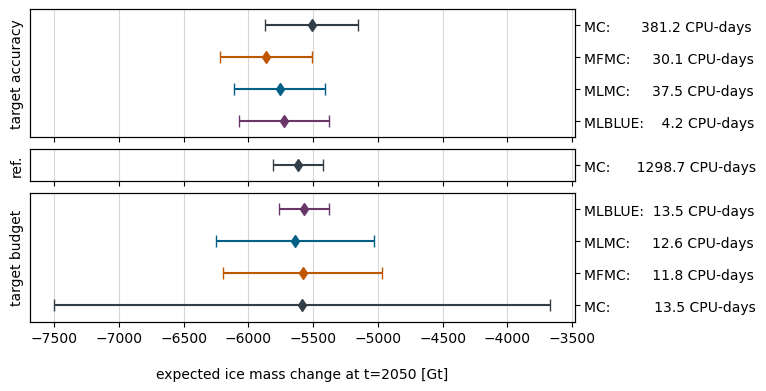

In [10]:
fig, axs = plt.subplots(3,1, figsize = (6, 3.5), sharex=True, height_ratios=[4, 1, 4])

for i in range(4):
    axs[0].plot([results[i, 1][0][-1]], [-i], 
                marker = "d", color=method_colors[i], label = method_names[i])
    
    axs[0].errorbar(x = [results[i, 1][0][-1]], 
            y = [-i], 
            xerr=1.96*results[i, 1][1][-1], 
            c=method_colors[i], 
            capsize = 4)
    
    axs[2].plot([results[i, 0][0][-1]], [i], 
                marker = "d", color=method_colors[i], label = method_names[i])
    
    axs[2].errorbar(x = [results[i, 0][0][-1]], 
            y = [i], 
            xerr=1.96*results[i, 0][1][-1], 
            c=method_colors[i], 
            capsize = 4)
    
axs[1].plot([result_ref[-1]], [0], 
                marker = "d", color=method_colors[0], label = method_names[0])

axs[1].errorbar(x = [result_ref[-1]], 
            y = [0], 
            xerr=1.96*mse_ref[-1], 
            c=method_colors[0], 
            capsize = 4)
    
axs[0].set_ylim(-3.5, 0.5)
axs[1].set_ylim(-0.5, 0.5)
axs[2].set_ylim(-0.5, 3.5)

for i in range(3):
    axs[i].grid(True, alpha=0.5)
    axs[i].set_yticks([],[])
    
axs[0].set_ylabel("target accuracy")
axs[1].set_ylabel("ref.")
axs[2].set_ylabel("target budget")

fig.tight_layout(pad=0.5)

ax2 = axs[0].twinx()
ax2.set_ylim((axs[0].get_ylim()[0], axs[0].get_ylim()[1]))
ax2.set_yticks([0, -1, -2, -3], ["MC:       381.2 CPU-days", 
                                 "MFMC:     30.1 CPU-days", 
                                 "MLMC:     37.5 CPU-days",
                                 "MLBLUE:    4.2 CPU-days"])

ax3 = axs[1].twinx()
ax3.set_ylim((axs[1].get_ylim()[0], axs[0].get_ylim()[1]))
ax3.set_yticks([0], ["MC:      1298.7 CPU-days"])

ax4 = axs[2].twinx()
ax4.set_ylim((axs[2].get_ylim()[0], axs[2].get_ylim()[1]))
ax4.set_yticks([3, 2, 1, 0], ["MLBLUE:  13.5 CPU-days", 
                              "MLMC:     12.6 CPU-days", 
                              "MFMC:     11.8 CPU-days", 
                              "MC:          13.5 CPU-days"])

axs[2].set_xlabel("\nexpected ice mass change at t=2050 [Gt]")

## projections for 2015-2050

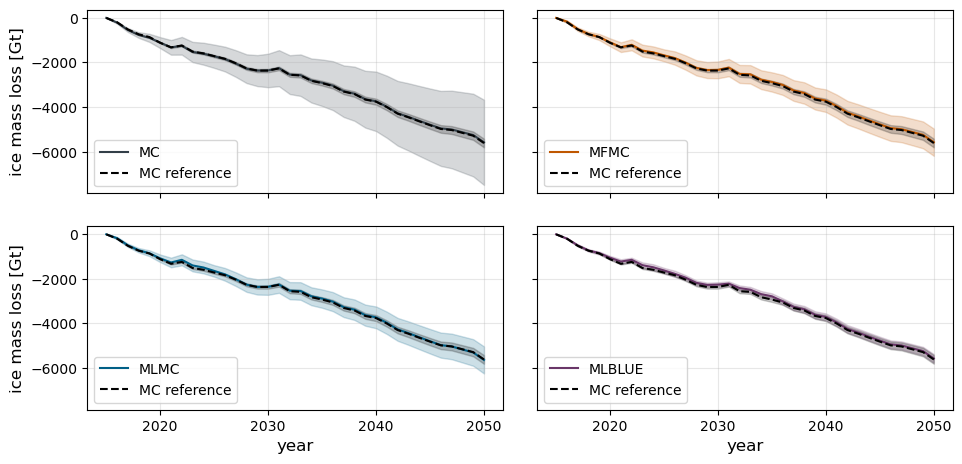

In [11]:
result_to_show = [results[i, 0][0] for i in range(4)]
mse_to_show = [results[i, 0][1] for i in range(4)]
my_labels = ["MC", "MFMC", "MLMC", "MLBLUE"]

fig, axs = plt.subplots(2,2, sharey=True, sharex = True, figsize = (10, 5))

i = 0
for row in range(2):
    for col in range(2):

        axs[row, col].fill_between(np.arange(2015, 2051), 
                            np.hstack([0,result_to_show[i] - 1.96*mse_to_show[i]]), 
                            np.hstack([0,result_to_show[i] + 1.96*mse_to_show[i]]), 
                            color = method_colors[i], alpha = 0.2)

        axs[row, col].plot(np.arange(2015, 2051), np.hstack([0,result_to_show[i]]), 
                color=method_colors[i], label = my_labels[i])

        axs[row, col].fill_between(np.arange(2015, 2051), 
                            np.hstack([0,result_ref - 1.96*mse_ref]), 
                            np.hstack([0,result_ref + 1.96*mse_ref]), 
                            color = "k", alpha = 0.2)

        axs[row, col].plot(np.arange(2015, 2051), np.hstack([0,result_ref]), 
                linestyle = "--", label = "MC reference", color = "k")

        axs[row, col].grid(True, alpha = 0.3)
        axs[row, col].legend(loc="lower left")

        i += 1
        
axs[1,0].set_xlabel("year", fontsize = 12)
axs[1,1].set_xlabel("year", fontsize = 12)
axs[0,0].set_ylabel("ice mass loss [Gt]", fontsize = 12)
axs[1,0].set_ylabel("ice mass loss [Gt]", fontsize = 12)

axs[1,0].set_xticks([2020, 2030, 2040, 2050], [2020, 2030, 2040, 2050])
axs[1,1].set_xticks([2020, 2030, 2040, 2050], [2020, 2030, 2040, 2050])

fig.tight_layout(pad=2.0)

## The End.

In [12]:
print("Runtime of this notebook: {} min".format((time.time()-tStart_notebook)/60))

Runtime of this notebook: 0.02172485589981079 min
